In [1]:
from tensorflow import keras
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D, AvgPool2D # new!
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras import backend as K
import keras_tuner as kt
from keras.callbacks import ModelCheckpoint, History, EarlyStopping

import random
import numpy as np
import matplotlib.pyplot as plt

import IPython as IPython

In [2]:
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
# Define the text labels
cifar10_labels = ["airplane",       # Index 0
                    "automobile",   # Index 1
                    "bird",         # Index 2
                    "cat",          # Index 3
                    "deer",         # Index 4
                    "dog",          # Index 5
                    "frog",         # Index 6
                    "horse",        # Index 7
                    "ship",         # Index 8
                    "truck"]        # Index 9


# Image index, you can pick any number between 0 and 59,999
img_index = random.randint(0,50000)

# y_train contains the lables, ranging from 0 to 9
label_index = y_train[img_index][0]

# Print the label, for random example
print ("y [" + str(img_index) + "]= " + str(label_index) + " " +cifar10_labels[label_index])


y [18257]= 6 frog


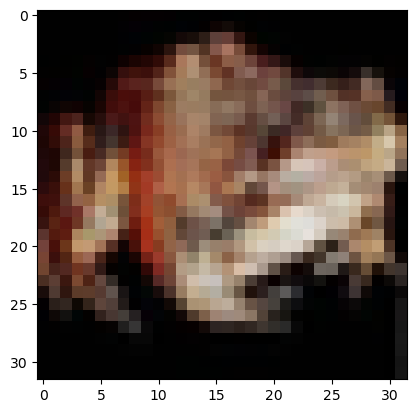

In [6]:
# Show one of the images from the training dataset
plt.imshow(x_train[img_index])

In [7]:
# A single pixel is of type Integer / values 0..255
print ("Ein Pixel aus der Mitte des Bildes. Datentyp:\t" , type (x_train[img_index][12][12]), "\nWert (0..255):\t\t\t\t\t", x_train[img_index][12][12])

Ein Pixel aus der Mitte des Bildes. Datentyp:	 <class 'numpy.ndarray'> 
Wert (0..255):					 [155 103  81]


In [8]:
# A complete image is stored as numpy Array
type (x_train[img_index])

numpy.ndarray

In [9]:
# We received 32x32x3 pixel images
x_train[img_index].shape

(32, 32, 3)

In [10]:
# In PyCharm we can display this 32x32x3 Image showing its Integer Numbers
x_train[img_index][31] # show column 31 for all 32 rows and 3 color layers

array([[ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 0,  2,  1],
       [ 0,  2,  1],
       [ 0,  2,  1],
       [ 0,  2,  1],
       [ 1,  1,  1],
       [ 2,  1,  1],
       [ 2,  1,  1],
       [ 2,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 0,  0,  0],
       [21, 21, 21]], dtype=uint8)

In [11]:
# We want to reshape all 60.000 images (and 10.000 test images) in order to give them one color-layer (not 3 color layers)
x_train = x_train.reshape(50000, 32, 32, 3).astype('float32')
x_test = x_test.reshape(10000, 32, 32, 3).astype('float32')

In [12]:
# We normalize Gray Scale to float 0..1
x_train /= 255
x_test /= 255

In [13]:
# We now have an extra dimension for the gray layer.
# The numbers stored ar floats
#type(x_train[img_index][12][12][0])
print ("Ein Pixel (3 Farben) aus der Mitte des Bildes. Datentyp:\t" , type (x_train[img_index][12][12]), "\nWert (0..255):\t\t\t\t\t", x_train[img_index][12][12])

Ein Pixel (3 Farben) aus der Mitte des Bildes. Datentyp:	 <class 'numpy.ndarray'> 
Wert (0..255):					 [0.60784316 0.40392157 0.31764707]


In [14]:
# An image is still an numpy array
type(x_train[img_index])

numpy.ndarray

In [15]:
# Shape of a single image has 32x32 Pixels and 3 color layers
x_train[img_index].shape

(32, 32, 3)

In [16]:
# We need to one-hot-encode our Y values
n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [17]:
# a simple VGG implementation prepared for Keras Tuner
# https://github.com/reedajohns/MiniVGGNet-in-Keras/blob/main/scripts/fundamentals/neuralnet/minivggnet.py
def model_builder(hp):
    # initialize the model along with the input shape to be
    # some basic parameters which allow adoption to other data sets
    height = 32
    width = 32
    depth = 3
    classes = 10
    
    # "channels last" and the channels dimension itself
    new_model = Sequential()
    input_shape = (height, width, depth)
    chan_dim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
        chan_dim = 1

    # first CONV => RELU => CONV => RELU => POOL layer set
    new_model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape, activation="relu"))
    new_model.add(BatchNormalization(axis=chan_dim))
    new_model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    new_model.add(BatchNormalization(axis=chan_dim))
    new_model.add(MaxPooling2D(pool_size=(2, 2)))
    new_model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    new_model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    new_model.add(BatchNormalization(axis=chan_dim))
    new_model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    new_model.add(BatchNormalization(axis=chan_dim))
    new_model.add(MaxPooling2D(pool_size=(2, 2)))
    new_model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    new_model.add(Flatten())
    new_model.add(Dense(512, activation="relu"))
    new_model.add(BatchNormalization())
    new_model.add(Dropout(0.5))

    # softmax classifier
    new_model.add(Dense(classes, activation="softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    new_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=hp_learning_rate), metrics=["accuracy"])
    # return the constructed network architecture
    return new_model



In [18]:
# Attention: If you change the tuner you need to remove the cache dir in directory='tuner_cifar_dir', in advance.
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='tuner_cifar_dir',
                     project_name='tune cifar mini vgg')

Reloading Tuner from tuner_cifar_dir\tune cifar mini vgg\tuner0.json


In [19]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [20]:
# also see: https://keras.io/guides/keras_tuner/visualize_tuning/
tuner.search(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

In [21]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal learning_rate for Adam is {best_hps.get('learning_rate')}.

""")


The hyperparameter search is complete.
The optimal learning_rate for Adam is 0.01.




In [22]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

In [23]:
# we can display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

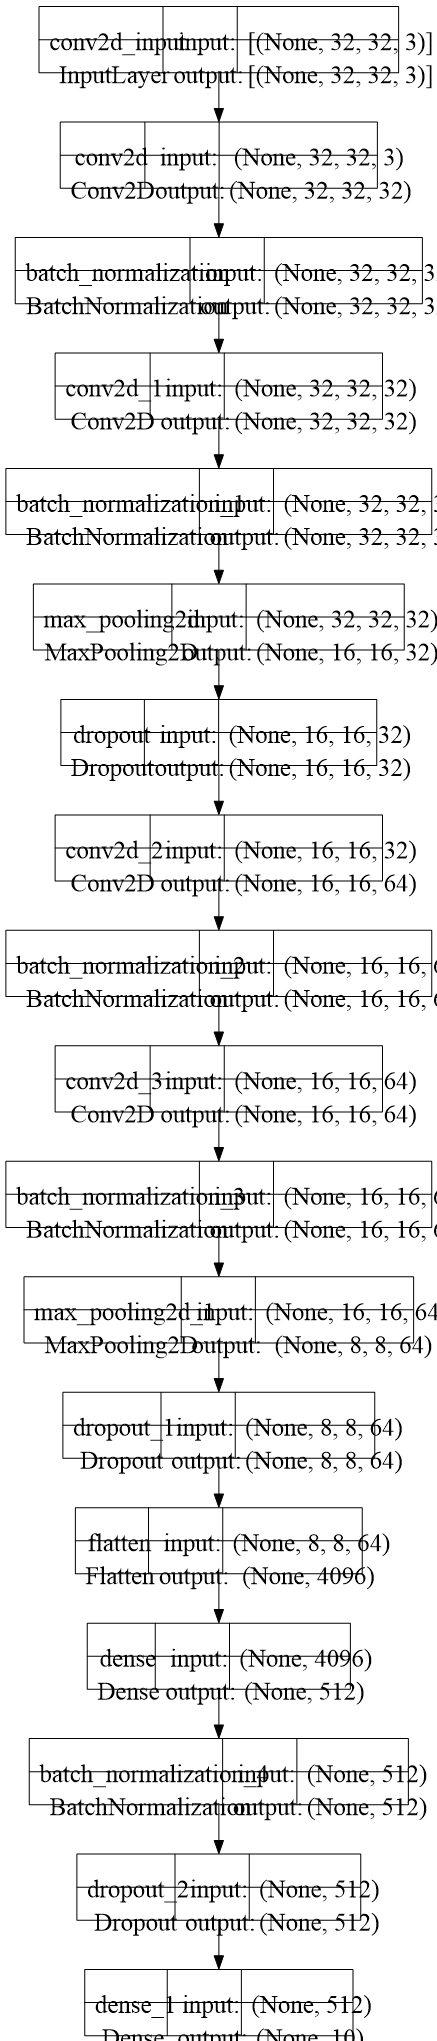

In [24]:
# Tensorflow allows to creat a visual representation of our model.
from keras.utils import plot_model

plot_model(model, to_file='../img/model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
### Optional - Hierfür müssen zusätziche Software und Bibliotheken installiert werden.

# import visualkeras
# from PIL import ImageFont

# font = ImageFont.truetype("arial.ttf", 64)  # using comic sans is strictly prohibited!

# visualkeras.layered_view(model, legend=True, font=font, scale_xy=20, scale_z=4, max_z=500)  # font is optional!


In [26]:
# we define two so called "callback" object.
# these objects can be injected to the training process.
# here: 
#   - the checkpointer callback collects the bestperforming model and stores the respective model parameters
#   - the history callback collects all metrics from all epochs
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)                     
history = History()

In [27]:
# the following model.fit runs about 40 minutes (for 10 epochs)

In [28]:
result = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1
                   #, validation_data=(x_valid, y_valid)
                   , validation_split=0.2
                   , callbacks = [history, checkpointer])

Epoch 1/40
312/313 [============================>.] - ETA: 0s - loss: 1.7644 - accuracy: 0.4148
Epoch 1: val_loss improved from inf to 1.99354, saving model to model.weights.best.hdf5
313/313 [==============================] - 20s 61ms/step - loss: 1.7636 - accuracy: 0.4151 - val_loss: 1.9935 - val_accuracy: 0.3554
Epoch 2/40
312/313 [============================>.] - ETA: 0s - loss: 1.1173 - accuracy: 0.6050
Epoch 2: val_loss improved from 1.99354 to 1.21985, saving model to model.weights.best.hdf5
313/313 [==============================] - 19s 62ms/step - loss: 1.1170 - accuracy: 0.6051 - val_loss: 1.2199 - val_accuracy: 0.5831
Epoch 3/40
312/313 [============================>.] - ETA: 0s - loss: 0.9215 - accuracy: 0.6763
Epoch 3: val_loss improved from 1.21985 to 0.86317, saving model to model.weights.best.hdf5
313/313 [==============================] - 21s 66ms/step - loss: 0.9217 - accuracy: 0.6762 - val_loss: 0.8632 - val_accuracy: 0.6947
Epoch 4/40
312/313 [=====================

In [29]:
history.history['loss']

[1.7635987997055054,
 1.117043137550354,
 0.9216651320457458,
 0.819694995880127,
 0.75723797082901,
 0.6921093463897705,
 0.64982008934021,
 0.6015439033508301,
 0.6156792640686035,
 0.557046115398407,
 0.514970064163208,
 0.48961323499679565,
 0.45872655510902405,
 0.4493055045604706,
 0.5465757846832275,
 0.42129990458488464,
 0.3809853792190552,
 0.359760582447052,
 0.3468612730503082,
 0.34100914001464844,
 0.3130638897418976,
 0.31715357303619385,
 0.29650676250457764,
 0.29742687940597534,
 0.28226980566978455,
 0.2659028172492981,
 0.26444870233535767,
 0.27579858899116516,
 0.2556901276111603,
 0.25336670875549316,
 0.23379990458488464,
 0.23698842525482178,
 0.2281668484210968,
 0.2205055207014084,
 0.2174227237701416,
 0.21551887691020966,
 0.20739389955997467,
 0.21592360734939575,
 0.2020995020866394,
 0.20174090564250946]

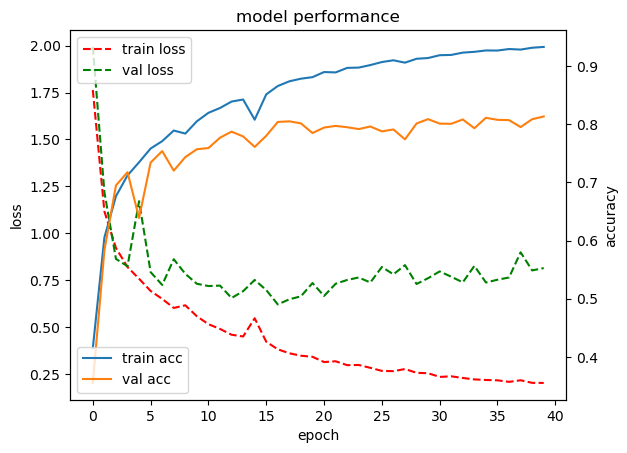

In [30]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], color='red', linestyle='--')
ax1.plot(history.history['val_loss'], color='green', linestyle='--')
plt.title('model performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss', 'train acc', 'val acc'], loc='upper left')

ax2 = ax1.twinx()

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('accuracy')
ax2.legend(['train acc', 'val acc'], loc='lower left')

In [31]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [32]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7972000241279602


In [33]:
y_hat = model.predict(x_test)


313/313 [==============================] - 2s 6ms/step


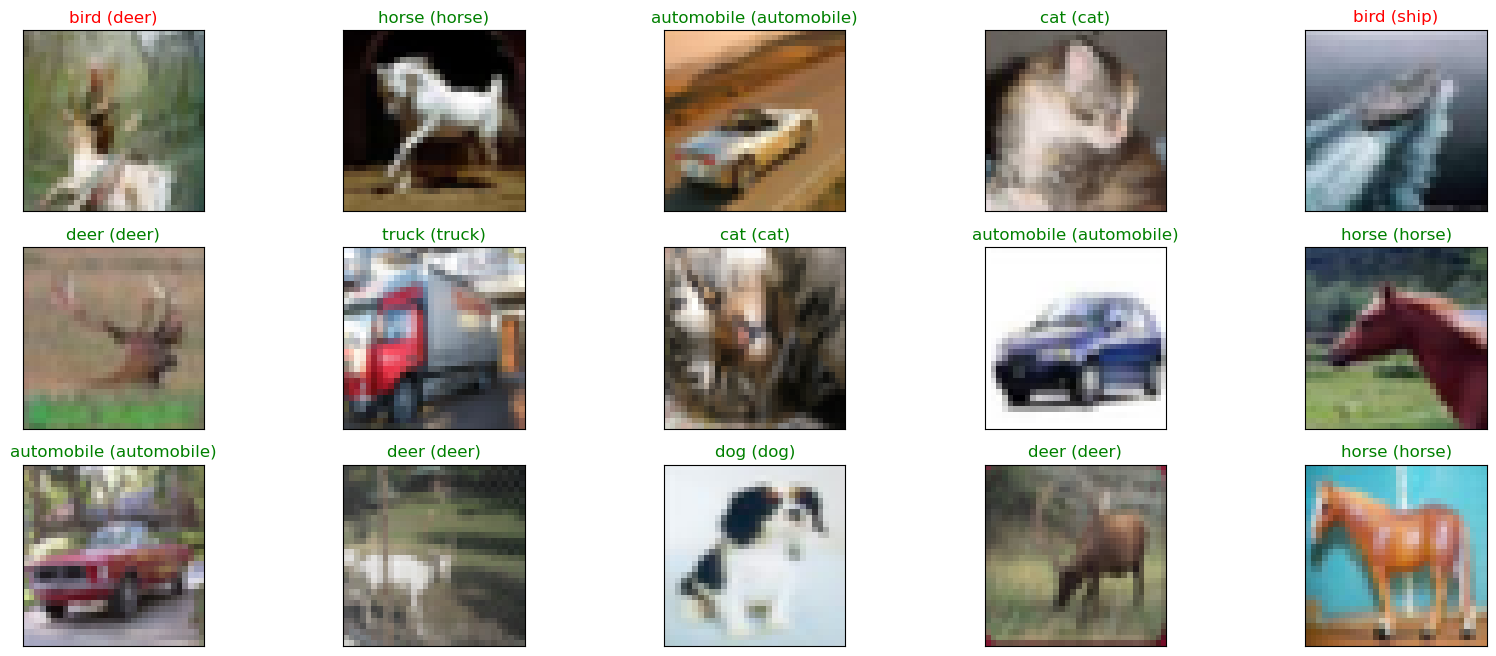

In [34]:
# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]), cmap='gray_r')
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(cifar10_labels[predict_index], 
                                  cifar10_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))